# Evaluate success of events

In [437]:
import pandas as pd
import numpy as np
import folium
import branca.colormap as cm
import joblib
import os
import io
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx

from Functions import *

In [438]:
api = "6c2695a3-768a-4885-a408-5770a99f5269"

### Load fitted model

In [439]:
buffer_size_m = 500
rf_model_pipeline1 = joblib.load('Results/FinalModels/rf_model_pipeline1_{}.pkl'.format(buffer_size_m))

### Read in Melbourne sensor location data

In [440]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

### Get data to make prediction on 

In [441]:
input_csv="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)
sensor_ids = pd.read_csv(input_csv)['sensor_id']

### Get data for just one day 

In [442]:
Xfull_with_dates = Xfull.copy()
Xfull['datetime'] = data_time_columns['datetime']
Xfull['datetime'] = pd.to_datetime(Xfull['datetime'], errors='coerce')

# Date of interest
special_date =  '2020-03-20' # '2015-04-25' # 2019-01-01 #2020-03-20

# Get data just from this date
special_date_data = Xfull[Xfull['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

# Get real vals from just this date
special_date_real_vals = pd.DataFrame({'Real_vals':Yfull, 'Hour': data_time_columns['time'],'datetime':data_time_columns['datetime']})
special_date_real_vals['datetime'] = pd.to_datetime(special_date_real_vals['datetime'], errors='coerce')
special_date_real_vals = special_date_real_vals[special_date_real_vals['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

In [443]:
special_date_real_vals = pd.DataFrame({'Real_vals':Yfull, 'Hour': data_time_columns['time'],'datetime':data_time_columns['datetime'],
                                      'sensor_id': sensor_ids})
special_date_real_vals['datetime'] = pd.to_datetime(special_date_real_vals['datetime'], errors='coerce')
special_date_real_vals = special_date_real_vals[special_date_real_vals['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

### Prepare it for using the model to make predictions

In [444]:
# If using the cyclical variables
special_date_data.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'year', 'datetime'], axis=1, inplace = True)

### Use the model to make predictions

In [445]:
preds = rf_model_pipeline1.predict(special_date_data)

### Make a dataframe containing the model's predictions and the real values

In [446]:
df_preds_real_vals = pd.DataFrame({'Preds':preds,'RealVals':special_date_real_vals['Real_vals'], 'Hour': special_date_real_vals['Hour'],
                                  'sensor_id': special_date_real_vals['sensor_id']})

### Find the sum of the values across all sensors for each hour

In [447]:
df_preds_real_vals_hourly =df_preds_real_vals.groupby(['Hour']).sum()

### Add percentage increase

In [448]:
df_preds_real_vals_hourly['Percentage_Increase'] = ((df_preds_real_vals_hourly['RealVals'] - df_preds_real_vals_hourly['Preds']) / abs(df_preds_real_vals_hourly['Preds'])) * 100

## Make line plot

In [449]:
include_percent_increase = True

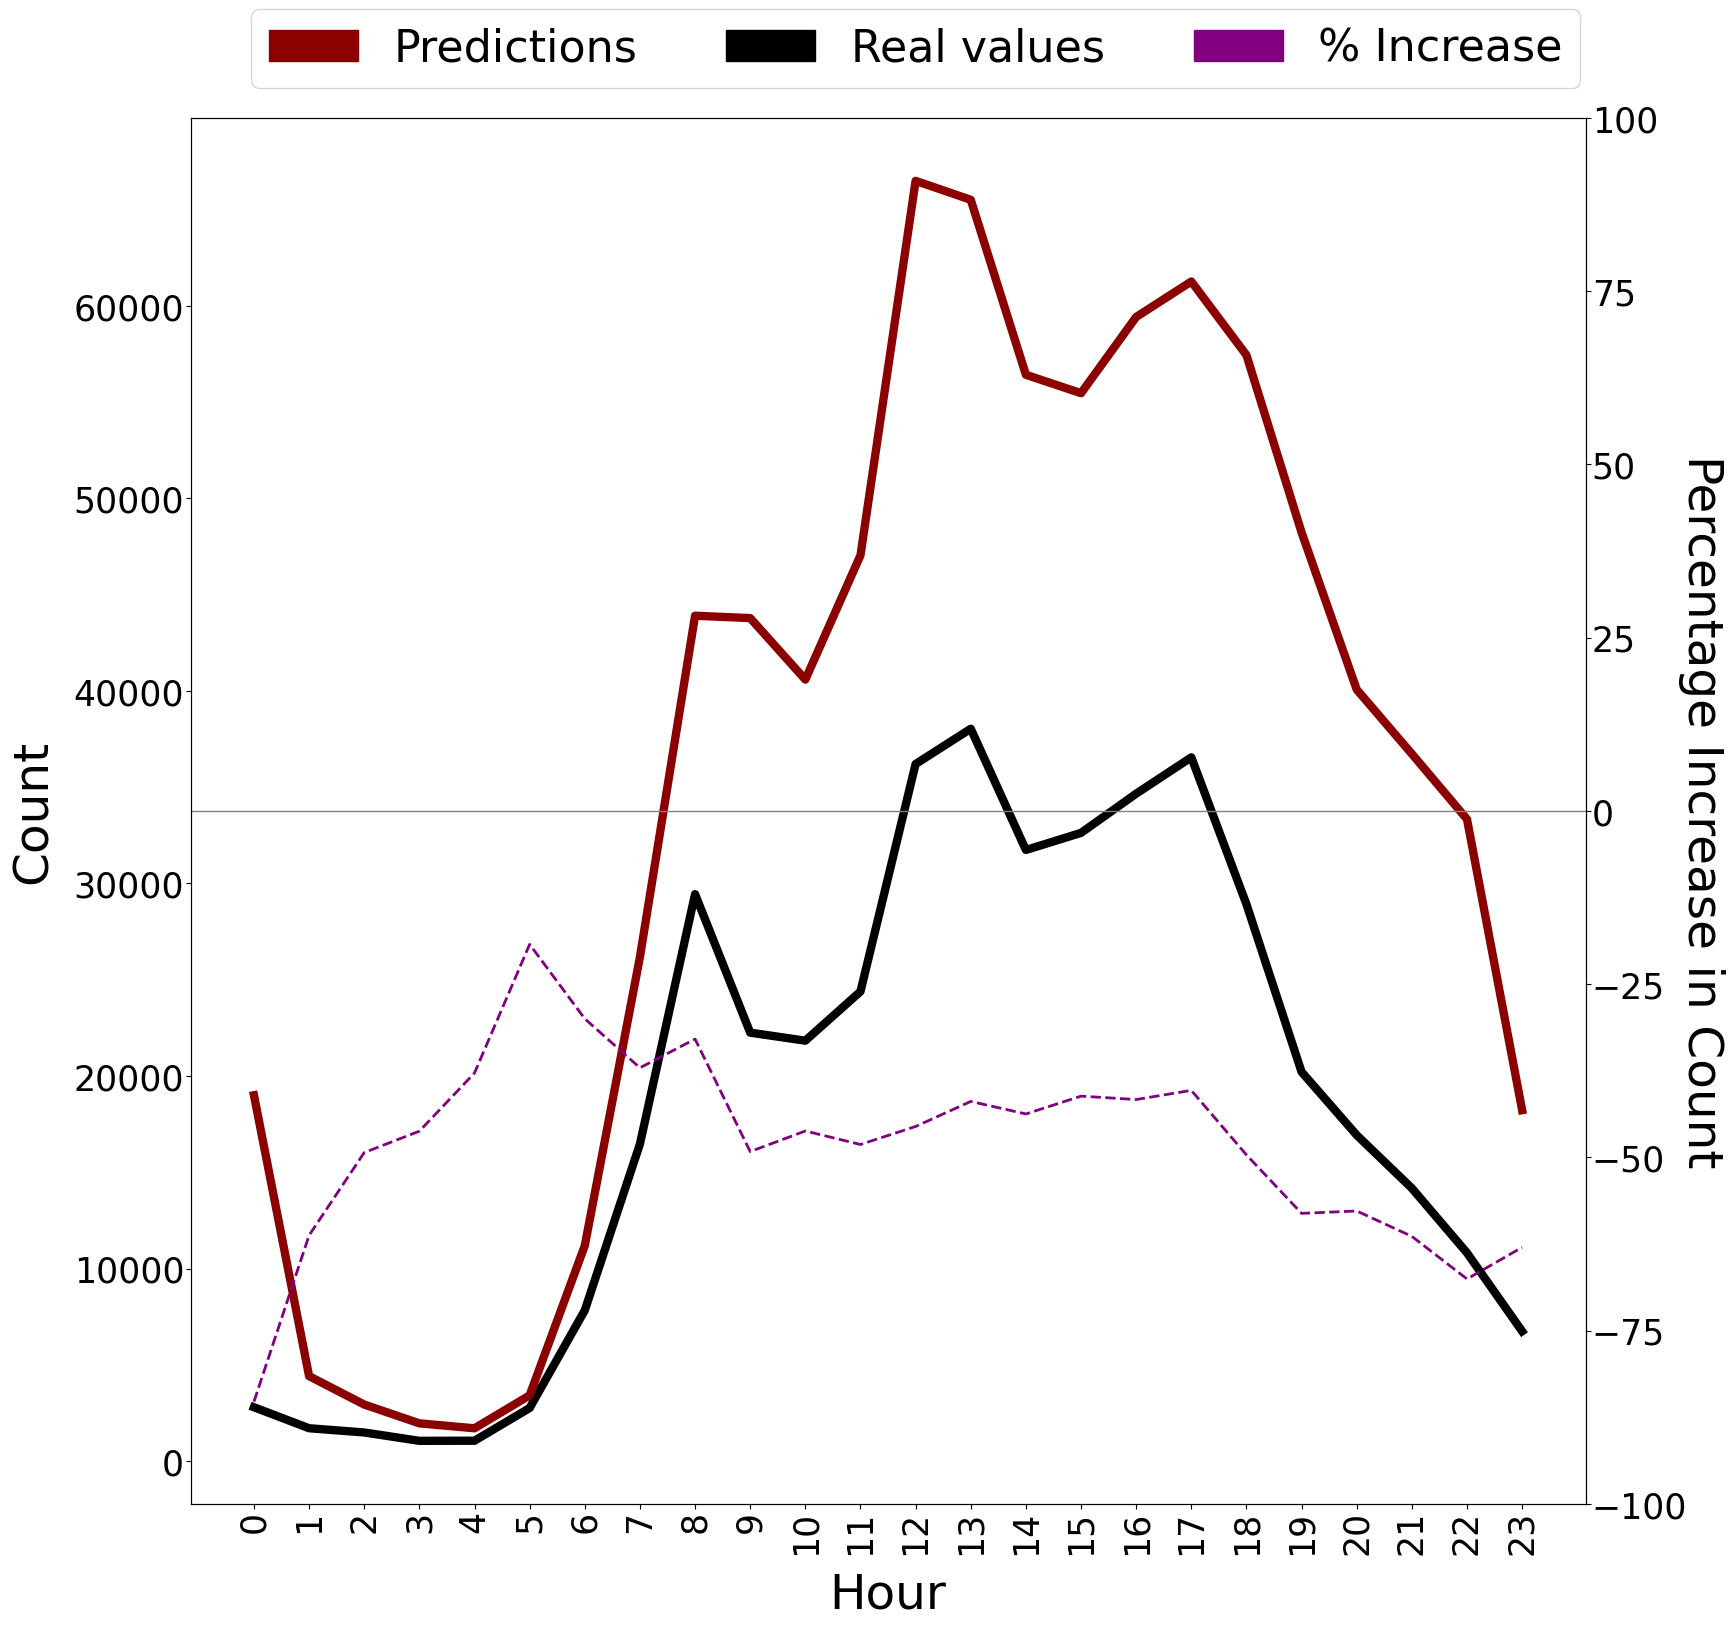

In [450]:
fig, ax = plt.subplots(figsize = (18,18), sharex = True)

fig = df_preds_real_vals_hourly['RealVals'].plot(ax=ax, color='black', linewidth=6, legend =False)
fig = df_preds_real_vals_hourly['Preds'].plot(ax=ax, color='darkred', linewidth=6, legend =False)

colors_leg = ['darkred', 'black', 'purple']
texts = ['Predictions', 'Real values','% Increase'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]    

ax.set_xticks(range(0,len(df_preds_real_vals_hourly.index)))
ax.set_xticklabels(df_preds_real_vals_hourly.index, size=15)
ax.tick_params(axis='both', which='major', labelsize=25, pad=1)

ax.set_xlabel('Hour', fontsize = 35, labelpad=12)
ax.set_ylabel ('Count',fontsize=35, labelpad=12)

if include_percent_increase==True:
    ax2 = ax.twinx()
    fig = df_preds_real_vals_hourly['Percentage_Increase'].plot(ax=ax2, color='purple', linewidth=2, legend =False,
                                                               linestyle = 'dashed')
    ax2.set_ylabel('Percentage Increase in Count', fontsize=35, rotation=270, labelpad=27)
    ax2.tick_params(axis='both', which='major', labelsize=25, pad=1)
    ax2.set_ylim(-100,100)

plt.axhline(y = 0, color = 'grey', linestyle = '-', linewidth=1)     
    
# ax.set_title(special_date)
ax.tick_params(axis='x', rotation=90)
plt.legend(handles=patches, bbox_to_anchor=(0.52, 1.05), loc='center', ncol=3, prop={'size': 32});
plt.savefig("Results/ModelEvaluation/Events/{}_lines.png".format(special_date), bbox_inches="tight" )
# plt.close() 

## Find errors by sensors

In [451]:
df_preds_real_vals_sensorly =df_preds_real_vals.groupby(['sensor_id']).sum()
df_preds_real_vals_sensorly.drop(['Hour'], axis=1, inplace=True)

### Add error metrics
df_preds_real_vals_sensorly['AbsolouteError'] = abs(df_preds_real_vals_sensorly['RealVals']-df_preds_real_vals_sensorly['Preds'])
df_preds_real_vals_sensorly['Error'] = df_preds_real_vals_sensorly['RealVals']-df_preds_real_vals_sensorly['Preds']
df_preds_real_vals_sensorly['Percentage_Increase'] = ((df_preds_real_vals_sensorly['RealVals'] - df_preds_real_vals_sensorly['Preds']) / abs(df_preds_real_vals_sensorly['Preds'])) * 100

# ### Join back with sensor geographic data
df_preds_real_vals_sensorly = pd.merge(df_preds_real_vals_sensorly, melbourne_sensors[['Latitude', 'Longitude', 'sensor_id']], on='sensor_id', how='left')
df_preds_real_vals_sensorly.head()

,sensor_id,Preds,RealVals,AbsolouteError,Error,Percentage_Increase,Latitude,Longitude
0,1,24721.84,15569,9152.84,-9152.84,-37.023296,-37.813494,144.965153
1,2,21574.61,12304,9270.61,-9270.61,-42.970000,-37.813807,144.965167
2,3,30053.61,15309,14744.61,-14744.61,-49.061028,-37.811015,144.964295
3,4,30618.53,18092,12526.53,-12526.53,-40.911598,-37.814880,144.966088
4,5,31909.54,12736,19173.54,-19173.54,-60.087171,-37.818742,144.967877


## Make spatial plot

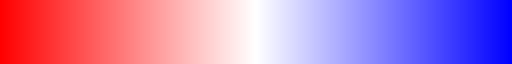

In [452]:
norm=plt.Normalize(-2,2)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
cmap

In [453]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-69.19517910546156, vcenter=0., vmax=40)

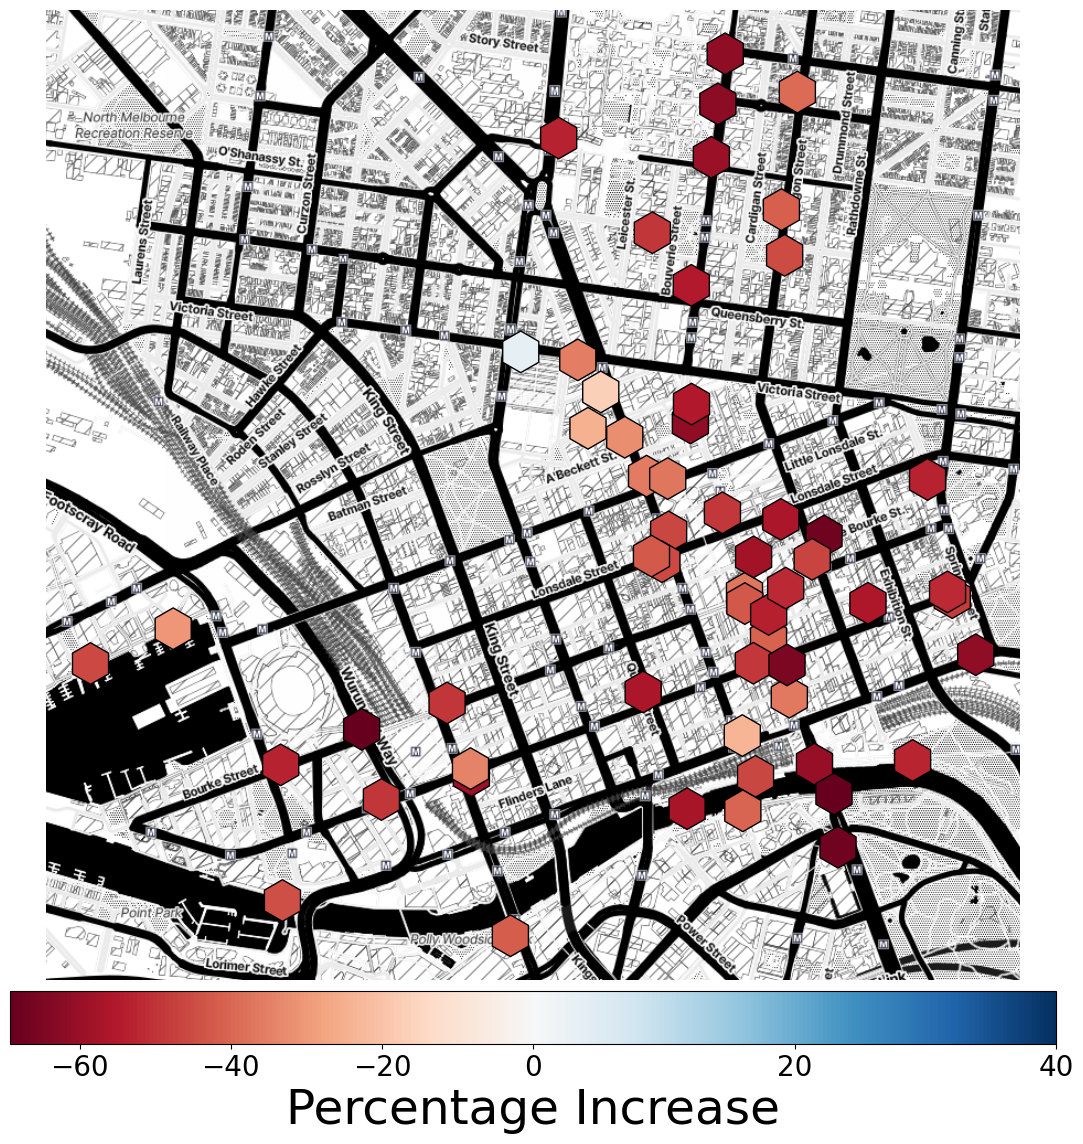

In [456]:
geometry = [Point(xy) for xy in zip(df_preds_real_vals_sensorly.Longitude, df_preds_real_vals_sensorly.Latitude)]
gdf = gpd.GeoDataFrame(df_preds_real_vals_sensorly, geometry=geometry)
gdf = gdf.set_crs('EPSG:4326')
gdf = gdf.to_crs('epsg:3857')

fig, ax = plt.subplots(figsize=(15,15))
gdf.plot(column=gdf.Percentage_Increase, ax = ax, markersize = 900,edgecolor = 'black', cmap="RdBu", norm=divnorm,
         marker='h', legend = True, 
         legend_kwds={'shrink': 0.9, 'pad':0.01, 'label':'Percentage Increase', 
                      "orientation": "horizontal"})

# Change font size on legend
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=20)
plt.rcParams.update({'font.size': 35}) # legend title size

cx.add_basemap(ax, source='https://tiles.stadiamaps.com/tiles/stamen_toner/{z}/{x}/{y}{r}.png?api_key='+api)
ax.axis('off')
ax.set_axis_off()

fig.savefig("Results/ModelEvaluation/Events/{}_spatial.png".format(special_date), bbox_inches="tight" )

## Make two plots together

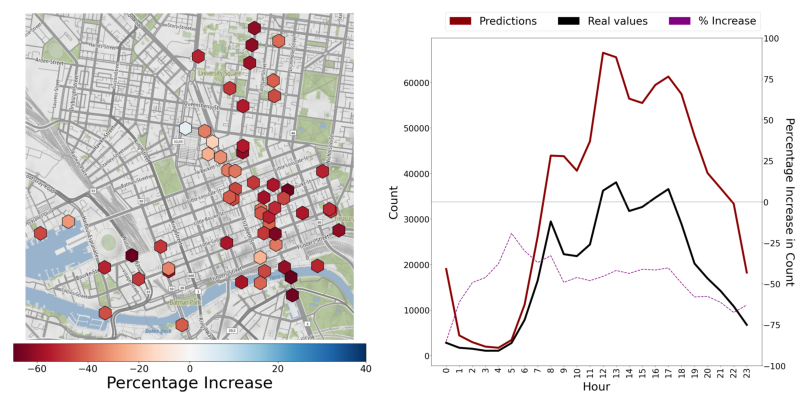

In [455]:
img1 = mpimg.imread('Results/ModelEvaluation/Events/{}_spatial.png'.format(special_date))
img2 = mpimg.imread('Results/ModelEvaluation/Events/{}_lines.png'.format(special_date))

fig, axs = plt.subplots(ncols= 2, nrows=1,figsize = (11,5), gridspec_kw={'wspace': -0.12})
axs[0].imshow(img1)
axs[0].axis('off')
axs[1].imshow(img2)
axs[1].axis('off');
plt.savefig('Results/ModelEvaluation/Events/{}_lines_spatial.png'.format(special_date), bbox_inches='tight')